# Least-Squared Method

## Approach
- Normalize data
- Cluster to number of variables (in this code, number of variables is 2)
- Find solution to system of two equations from cluster
- Find solution algebraically
- Compare solutions and see how they differ

In [2]:
# Imports

import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

## Creating Data
* `readcsv`: Takes in a csv file and imports that data
    * Input: a filename (e.g. "testdata.csv")
    * Output: a matrix where each row represents an equation
* `makedata`: Takes in a number of equations and a standard deviation, and generates that number of equations randomly. Equations are stored in a matrix.
    * Input: a natural number with the number of equations `numpoints`, with points clustered along a random line with standard deviation `stddev`
    * Output: the x points, the y points, and a matrix where each row represents an equation

In [3]:
# TODO - Change so that reading from csv is formatted for least squares regression
def readcsv(filename):
    matrix = []
    
    with open(filename) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            matrix += [row]
    return np.array(matrix).astype(float)

In [4]:
def makedata(numpoints, stddev):
    X = [] # Design matrix
    Y = []
    matrix = [] # of the form [1, x, y] for each row
    
    # Get parameters m and b for y = mx + b
    m = random.uniform(0.25, 2) * (math.pow(-1, random.randint(0,2)))
    b = random.uniform(-10, 10)
    for j in range(numpoints):
        x = random.uniform(-10, 10)
        e = random.gauss(0, stddev)
        y = m * x + b + e
        X += [[1, x]]
        Y += [y]
        matrix += [[1, x, y]]
    return np.array(X), np.array(Y), np.array(matrix)

## Normalizing Data
* `normalize`: Use the L2 norm to normalize the data to make every equation in a matrix have a unit normal
    * Input: matrix with rows as equations
    * Output: matrix with each row having equations with unit norms

In [5]:
# Normalize each row of the matrix
def normalize(matrix):
    normMatrix = []
    for i in range(len(matrix)):
        vector = np.array(matrix[i][:(len(matrix[i]) - 1)])
        norm = np.linalg.norm(vector)        
        normVector = matrix[i] / norm
        normMatrix += [normVector]
    return np.array(normMatrix)

## Clustering Data Points
* Overall approach: Use k-means clustering
* To find the actual optimal cluster of k, plot the sum squared errors with each k, and find an "elbow" in the graph. The location of that elbow indicates what k we should cluster with

### Functions
* `bestkcluster`: Plots a graph of the sum squared errors clustering with different values of k
    * Input: a matrix of equations `matrix`, the maximum number of clusters to test `maxclusters`
* `kcluster`: Cluster the equations of the system into a specified number of clusters
    * Input: matrix of equations `matrix`, the number of clusters `k`
    * Output: matrix of equations representing the center of the clusters

In [6]:
# Plot sum of squared errors for k means clustering
# for each k <= maxclusters
# Elbow of graph = optimal number of clusters
def bestkcluster(matrix, maxclusters):
    sse = [] # sum of squared distances for each k
    for k in range(1, maxclusters+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix)
        centers = kmeans.cluster_centers_
        sse += [sum(np.min(cdist(matrix, centers, 'euclidean'), axis=1)) / matrix.shape[0]]
    plt.plot(list(range(1,maxclusters+1)), sse)
    plt.show()
    
# Find the clusters for k means clustering for a
# given k. Use bestkcluster to find optimal k
def kcluster(matrix, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(matrix)
    return kmeans.cluster_centers_

## Finding Solutions

* `algsolution`: Algebraically finds the solution to the system of equations
    * Input: matrix with rows of the form ax + by = d
    * Output: Solution as (x, y)
* `solution`: Solves the system of equations when the system is not overdetermined
    * Input: matrix with rows of the form ax + by = d, and number of rows are one less then the number of columns
    * Output: Solution as (x, y)
* `avgsolution`: Take all subsets of an overdetermined system that together gives a solution, then averages among the solutions
    * Input: matrix with rows of the form ax + by = d
    * Output: Solution as (x, y)

In [7]:
# Find the solution algebraically
# Input: matrix with rows of the form ax + by = c
# Output: a tuple that is the solution
def algsolution(matrix):
    
    # Equation of the form Ax = b
    A = matrix[:, :2]
    b = matrix[:, 2]
    
    # Estimate x = (A.T A)^-1 (A.T y) = B^-1 c
    # for B = (A.T A) and c = A.T y
    B = np.dot(np.transpose(A), A)
    c = np.dot(np.transpose(A), b)
    x = np.dot(np.linalg.inv(B), c)
    return x

In [8]:
# Find the algebraic solution but
# splitting up the region
def algsolutionsplit(matrix):
    m = matrix
    totalx0 = 0
    totalx1 = 0
    count = 0
    while len(m) > 0:
        sol = algsolution(m[:50]) # max 50 rows
        totalx0 += sol[0]
        totalx1 += sol[1]
        count += 1
        m = m[50:]
    return (totalx0 / count, totalx1 / count)

In [9]:
# When system is not overdetermined,
# try to find solution
def solution(matrix):
    if len(matrix) != len(matrix[0]) - 1:
        print("Overdetermined system")
    coefficients = [matrix[0][:len(matrix[0])-1], matrix[1][:len(matrix[1])-1]]
    consts = [matrix[0][len(matrix[0])-1], matrix[1][len(matrix[1])-1]]
    return np.linalg.solve(coefficients, consts)

In [10]:
# For an overdetermined system, find solutions pairwise
# and take the average of the solutions
def avgsolution(matrix):
    solutions = []
    totalx = 0
    totaly = 0
    for i in range(len(matrix)-1):
        for j in range(i+1, len(matrix)):
            coefficients = [matrix[i][:len(matrix[i])-1], matrix[j][:len(matrix[j])-1]]
            consts = [matrix[i][len(matrix[i])-1], matrix[j][len(matrix[j])-1]]
            sol = np.linalg.solve(coefficients, consts)
            solutions += [sol]
            totalx += sol[0]
            totaly += sol[1]
    numsolutions = len(matrix) * (len(matrix) - 1) / 2
    return (totalx / numsolutions, totaly / numsolutions)

In [11]:
# Split finding the solutions
def avgsolutionsplit(matrix):
    # Split to 50 points per segment
    m = matrix
    totalx = 0
    totaly = 0
    count = 0
    while len(m) > 0:
        subset = m[:50] # first 50
        x, y = geosolution(subset)
        count += 1
        totalx += x
        totaly += y
        m = m[50:]
    return (totalx / count, totaly / count)

## Graphing

* `graphVectors`: graphs a set of unit vectors for each equation in a matrix
    * Input: matrix with rows being normalized linear equations
* `graphpoints`: graphs all points in a scatterplot
    * Input: `x` points, `y` points
* `graphclusters`: graphs all points in a scatterplot and the centers of the clusters
    * Input: the array of centers of the clusters `clusters`, `X` points, `Y` points
* `graphpointswithline`: graphs all points in a scatterplot with two lines
    * Input: `x` points, `y` points, the algebraic solution `alg` in the form (b0, b1), the geometric solution `geo` in the form (b0, b1), 

In [12]:
# Input: normalized matrix (see normalize function)
# Draws 3D vectors
def graphVectors(nmatrix):
    X = []
    Y = []
    for i in range(len(nmatrix)):
        X += [nmatrix[i][0]]
        Y += [nmatrix[i][1]]
    
    origin = [0], [0]
    plt.figure()
    ax = plt.gca()
    ax.quiver(*origin, X, Y, angles='xy', scale_units='xy', scale = 1)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    plt.plot(0,0, 'ro')
    plt.draw()
    plt.show()

In [13]:
# Graph points to regress on
def graphpoints(x,y):
    plt.scatter(x,y)
    plt.show()

In [14]:
def graphclusters(cluster, X, Y):
    # Make the constant term = 1
    x = []
    y = []
    print("Points:")
    for eq in cluster:
        scaledeq = eq / eq[0]
        x += [scaledeq[1]]
        y += [scaledeq[2]]
        print((scaledeq[1],scaledeq[2]))
    plt.plot(x, y, 'ro', label = "Clusters")
    plt.scatter(X, Y, label = "Data")
    plt.legend()
    plt.show()

In [15]:
# Graph points with predicted line
def graphpointswithline(x,y,alg,geo):
    xx = np.linspace(-10, 10, 1000)
    plt.plot(xx, alg[0] + (xx * alg[1]), 'r-', label = "Algebraic")
    plt.plot(xx, geo[0] + (xx * geo[1]), 'g-', label = "Geometric")
    plt.legend()
    plt.scatter(x,y, c='black')
    plt.show()

## Parameters
* In cell below...
    * Can adjust `numpoints` parameter below to adjust number of points
    * Can adjust standard deviation of points `stdev`

In [28]:
numpoints = 1000
stdev = 1
X, Y, data = makedata(numpoints, stdev)

## Run Script
Go through all of the steps to determine the algebraic and geometric solutions, and compare the two solutions

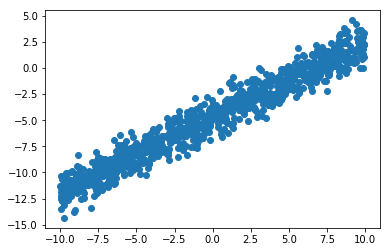

Normal Vectors:


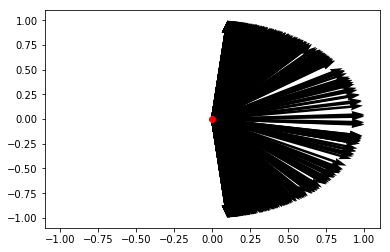

Sum of Squared Errors for each k


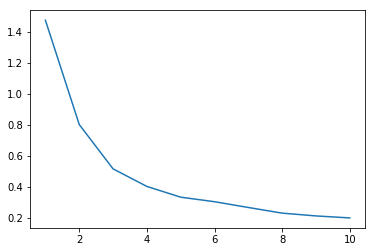

Clusters found with k = 2:
0.21479190571366155b0 + 0.9684917951063026b1 = -0.300584353326929
0.3435964792959642b0 + -0.711271057436797b1 = -2.1351059429884858


Graph of clustered points:
Points:
(4.508977151110136, -1.3994212320441772)
(-2.0700766750992474, -6.21399249306442)


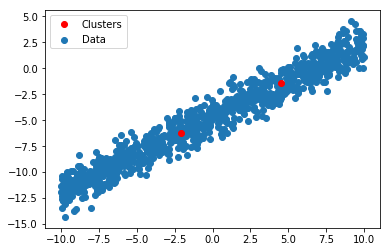

Geometric Solution:
y = -4.699104192814179+ 0.7318029899436507x


Algebraic Solution
y = -4.706568780892998+ 0.713135945792178x


Algebraic Solution (red) and Geometric Solution (blue):


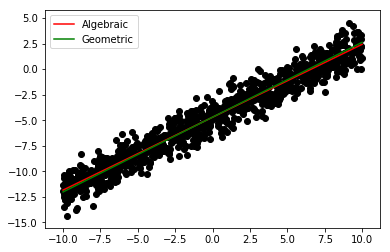

Component-wise difference: [0.00746459 0.01866704]
L2 Error: 0.020104193904244935


In [29]:
graphpoints(X[:,1], Y)
data = normalize(data)
print("Normal Vectors:")
graphVectors(data)

print("Sum of Squared Errors for each k")
bestkcluster(data, 10)

# Always force cluster to 2
cluster = kcluster(data, 2)
print("Clusters found with k = 2:")
for c in cluster:
    print(str(c[0]) + "b0 + " + str(c[1]) +"b1 = " + str(c[2]))
print("\n")

print("Graph of clustered points:")
graphclusters(cluster, X[:, 1], Y)

print("Geometric Solution:")
geo = solution(cluster)
print("y = " + str(geo[0]) + "+ " + str(geo[1]) + "x")

print("\n")
print("Algebraic Solution")
alg = algsolutionsplit(data)
print("y = " + str(alg[0]) + "+ " + str(alg[1]) + "x")
print("\n")

print("Algebraic Solution (red) and Geometric Solution (blue):")
graphpointswithline(X[:, 1], Y, alg, geo)

error = np.array([np.abs(alg[0] - geo[0]), np.abs(alg[1] - geo[1])])
print("Component-wise difference: " + str(error))
sse = np.sum(error**2)**.5
print("L2 Error: " + str(sse))

## Numpy Method
Numpy's built-in least-squared regression algorithm)

LSR with numpy:
y = 4.649492221241827 + 0.6677856746779012x
LSR algebraic:
y = 4.780468131053334 + 0.656435912144858x
LSR geometric:
y = 5.26269468736324 + 5.174661414061645x


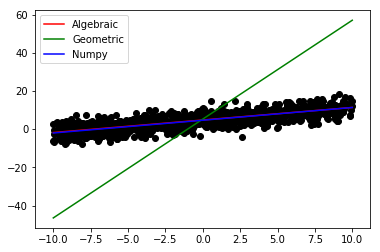

Component-wise difference for algebraic: [0.13097591 0.01134976]
L2 Error: 0.13146674887783819


Component-wise difference for geometric: [0.61320247 4.50687574]
L2 Error: 4.548400399558415


In [18]:
# Using numpy's least squared regression
b, m = np.linalg.lstsq(X, Y, rcond=None)[0] # for y = mx + b
print("LSR with numpy:")
print("y = " + str(b) + " + "+ str(m) + "x")
print("LSR algebraic:")
print("y = " + str(alg[0]) + " + " + str(alg[1]) + "x")
print("LSR geometric:")
print("y = " + str(geo[0]) + " + " + str(geo[1]) + "x")

xx = np.linspace(-10, 10, 1000)
plt.plot(xx, alg[0] + (xx * alg[1]), 'r-', label = "Algebraic")
plt.plot(xx, geo[0] + (xx * geo[1]), 'g-', label = "Geometric")
plt.plot(xx, b + (xx * m), 'b-', label = "Numpy")
plt.legend()
plt.scatter(X[:,1],Y, c='black')
plt.show()

errora = np.array([np.abs(alg[0] - b), np.abs(alg[1] - m)])
print("Component-wise difference for algebraic: " + str(errora))
ssea = np.sum(errora**2)**.5
print("L2 Error: " + str(ssea))
print("\n")

errorb = np.array([np.abs(geo[0] - b), np.abs(geo[1] - m)])
print("Component-wise difference for geometric: " + str(errorb))
sseb = np.sum(errorb**2)**.5
print("L2 Error: " + str(sseb))

## Comparing standard deviation and error
* Observation: the higher the standard deviation, the higher the error is between the algebraic and geometric solution
* Observation: ln(standard deviation) and ln(L2 error beteween the algebraic and geometric solution) may be linearly correlated (although there is more noise as the standard deviation increases)

In [19]:
def makesamedata(numpoints, stddev, m, b):
    X = [] # Design matrix
    Y = []
    matrix = [] # of the form [1, x, y] for each row
    
    # Get parameters m and b for y = mx + b
    for j in range(numpoints):
        x = random.uniform(-10, 10)
        e = random.gauss(0, stddev)
        y = m * x + b + e
        X += [[1, x]]
        Y += [y]
        matrix += [[1, x, y]]
    return np.array(X), np.array(Y), np.array(matrix)

In [20]:
# Run Script in a function
def finderror(numPoints, stDev, m, b):
    numpoints = numPoints
    stdev = stDev
    X, Y, data = makesamedata(numpoints, stdev, m, b)
    data = normalize(data)

    # Always force cluster to 2
    cluster = kcluster(data, 2)

    geo = solution(cluster)
    alg = algsolutionsplit(data)

    error = np.array([np.abs(alg[0] - geo[0]), np.abs(alg[1] - geo[1])])
    sse = np.sum(error**2)**.5
    return sse

(1, -2.9127716752231883)
(51, 6.88468192974536)
(101, 8.06514326221456)
(151, 6.4882002361093685)
(201, 7.827879474336747)
(251, 9.086145228056024)
(301, 7.734836850119058)
(351, 8.961205284454367)
(401, 9.696891901106673)
(451, 7.223539448153445)


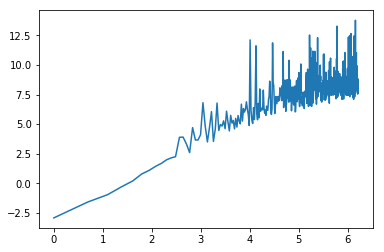

In [21]:
stdevs = []
logerrors = []
m = random.uniform(0.25, 2) * (math.pow(-1, random.randint(0,2)))
b = random.uniform(-10, 10)
for i in range(1, 500):
    stdevs += [math.log(i)]
    e = math.log(finderror(1000, i, m, b))
    logerrors += [e]
    if i % 50 == 1: # For checking progress
        print((i, e))
plt.plot(stdevs, logerrors)
plt.show()